In [144]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import log_loss

from lightgbm import LGBMClassifier

In [145]:
# read data
train_data_path = "./train.csv"
test_data_path = "./test.csv"

data = pd.read_csv(train_data_path)
print(data.head(10))

   Activity        D1        D2    D3    D4        D5        D6        D7  \
0         1  0.000000  0.497009  0.10  0.00  0.132956  0.678031  0.273166   
1         1  0.366667  0.606291  0.05  0.00  0.111209  0.803455  0.106105   
2         1  0.033300  0.480124  0.00  0.00  0.209791  0.610350  0.356453   
3         1  0.000000  0.538825  0.00  0.50  0.196344  0.724230  0.235606   
4         0  0.100000  0.517794  0.00  0.00  0.494734  0.781422  0.154361   
5         0  0.133333  0.771035  0.20  0.25  0.122153  0.677398  0.267224   
6         1  0.066700  0.567401  0.10  0.00  0.116578  0.689802  0.274886   
7         1  0.133333  0.610057  0.15  0.00  0.105176  0.759602  0.313393   
8         1  0.000000  0.776816  0.05  0.00  0.458446  0.738631  0.246347   
9         0  0.100000  0.768150  0.10  0.25  0.262299  0.598972  0.377065   

         D8        D9  ...  D1767  D1768  D1769  D1770  D1771  D1772  D1773  \
0  0.585445  0.743663  ...      0      0      0      0      0      0     

In [146]:
# check missing value
print("Missing value", data.isnull().sum().sum())
print("Column names", data.columns)

Missing value 0
Column names Index(['Activity', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9',
       ...
       'D1767', 'D1768', 'D1769', 'D1770', 'D1771', 'D1772', 'D1773', 'D1774',
       'D1775', 'D1776'],
      dtype='object', length=1777)


In [147]:
df_float = data.select_dtypes(include=[float])
print("Float column", df_float.columns)

df_int = data.select_dtypes(include=[int])
print("Int column", df_int.columns)

df_object = data.select_dtypes(include=[object])
print("Object column", df_object.columns)

Float column Index(['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10',
       ...
       'D942', 'D943', 'D944', 'D945', 'D946', 'D947', 'D948', 'D949', 'D950',
       'D951'],
      dtype='object', length=942)
Int column Index(['Activity', 'D23', 'D27', 'D28', 'D51', 'D72', 'D94', 'D170', 'D568',
       'D858',
       ...
       'D1767', 'D1768', 'D1769', 'D1770', 'D1771', 'D1772', 'D1773', 'D1774',
       'D1775', 'D1776'],
      dtype='object', length=835)
Object column Index([], dtype='object')


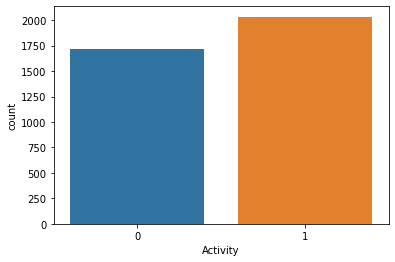

In [148]:
g1 = sns.countplot(x=data["Activity"])

In [149]:
# find distribution of labels
scaled_data = MinMaxScaler().fit_transform(data)
data = pd.DataFrame(scaled_data, columns=data.columns)

Text(0, 0.5, 'cumulative explained variance')

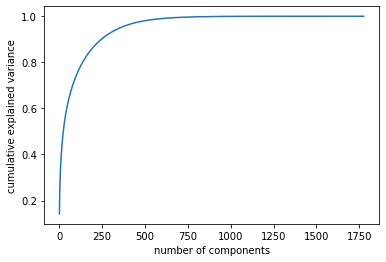

In [150]:
# Look at the cumulative explained
pca = PCA().fit(data)
# print(pca.explained_variance_ratio_[0:20])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("number of components")
plt.ylabel("cumulative explained variance")

In [151]:
y = data['Activity']
X = data.drop(columns="Activity")

pca = PCA(n_components=750)
pca_X = pca.fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3751 samples in 0.004s...
[t-SNE] Computed neighbors for 3751 samples in 0.527s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3751
[t-SNE] Computed conditional probabilities for sample 2000 / 3751
[t-SNE] Computed conditional probabilities for sample 3000 / 3751
[t-SNE] Computed conditional probabilities for sample 3751 / 3751
[t-SNE] Mean sigma: 2.770370
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.043549
[t-SNE] KL divergence after 1000 iterations: 0.800155


<AxesSubplot:xlabel='comp1', ylabel='comp2'>

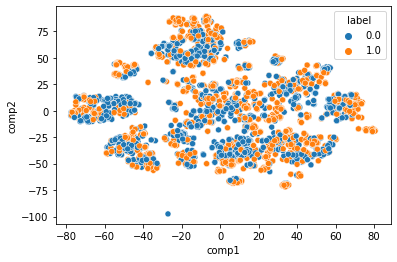

In [152]:
tsne_result = TSNE(verbose=1).fit_transform(pca_X)

df_tsne = pd.DataFrame(data=tsne_result, columns=["comp1", "comp2"])
df_tsne["label"] = y
sns.scatterplot(x="comp1", y="comp2", data=df_tsne, hue='label')

In [153]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

training = train.drop(columns='Activity')
training['label'] = 0
test['label'] = 1
combine = training.append(test)

y = combine['label']
combine.drop(columns='label', inplace=True)

model = LGBMClassifier(n_estimators=50)
drop_list = []
for col in combine.columns:
    scores = cross_val_score(model, pd.DataFrame(combine[col]), y, cv=2, scoring='roc_auc')
    if np.mean(scores) > 0.7:
        drop_list.append(col)
        print("Column with covariate shift:", col)

if len(drop_list) == 0:
    print("No presence of covariate shift")

No presence of covariate shift


In [154]:
data = pd.read_csv(train_data_path)

X = data
X = X.drop(columns='Activity')

y = data['Activity']
y = y.values.reshape(len(y), 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=32)

def normalizing(x_train, x_test):
    columns = x_train.columns
    for c in columns:
        scale = MinMaxScaler()

        x_train_arr = x_train[c].astype(float).values.reshape(-1, 1)
        x_test_arr = x_test[c].astype(float).values.reshape(-1, 1)

        x_train_arr = scale.fit_transform(x_train_arr)
        x_test_arr = scale.transform(x_test_arr)

        # https://stackoverflow.com/questions/31468176/setting-values-on-a-copy-of-a-slice-from-a-dataframe
        x_train_result = x_train.copy()
        x_test_result = x_test.copy()
        x_train_result.loc[:, c] = x_train_arr
        x_test_result.loc[:, c] = x_test_arr
        return x_train_result, x_test_result

X_train, X_test = normalizing(X_train, X_test)

In [155]:
param_test = {
    'n_estimators': [50, 100, 200, 400, 800, 1000],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15, 20, 25],
    'num_leaves': [50, 100, 200],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
}

fit_params = {
    "early_stopping_rounds": 100,
    "eval_metric": 'binary_logloss',
    "eval_set": [(X_test, y_test)],
    'eval_names': ['valid'],
    'verbose': 100,
    'categorical_feature': 'auto'
}

In [156]:
clf = LGBMClassifier(random_state=314, silent=True, n_jobs=2)
model = RandomizedSearchCV(clf, param_distributions=param_test, scoring='neg_log_loss',
                           cv=3, refit=True, random_state=314, verbose=True)
model.fit(X_train, y_train, **fit_params)
print("Best score reached: {} with params: {}".format(model.best_score_, model.best_params_))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.44901
Early stopping, best iteration is:
[59]	valid's binary_logloss: 0.447262


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.458212
Early stopping, best iteration is:
[64]	valid's binary_logloss: 0.455091


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.440613
Early stopping, best iteration is:
[55]	valid's binary_logloss: 0.437292


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.448824
Early stopping, best iteration is:
[61]	valid's binary_logloss: 0.446255


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.467263
Early stopping, best iteration is:
[62]	valid's binary_logloss: 0.461906


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.429307
Early stopping, best iteration is:
[60]	valid's binary_logloss: 0.424833


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.449844


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.463127


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.441926


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.449451
Early stopping, best iteration is:
[65]	valid's binary_logloss: 0.445927


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.463141
Early stopping, best iteration is:
[56]	valid's binary_logloss: 0.459639


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.447529
[200]	valid's binary_logloss: 0.443511
Early stopping, best iteration is:
[151]	valid's binary_logloss: 0.442552


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.442725
Did not meet early stopping. Best iteration is:
[62]	valid's binary_logloss: 0.440011


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.461038
Did not meet early stopping. Best iteration is:
[47]	valid's binary_logloss: 0.457281


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.440354
Did not meet early stopping. Best iteration is:
[66]	valid's binary_logloss: 0.435377


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.444569


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.461524


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.434551


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.445985
Early stopping, best iteration is:
[91]	valid's binary_logloss: 0.444351


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.474721
Early stopping, best iteration is:
[59]	valid's binary_logloss: 0.460402


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.448021
Early stopping, best iteration is:
[55]	valid's binary_logloss: 0.441512


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.454359


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.466454


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's binary_logloss: 0.440951


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.446952
Early stopping, best iteration is:
[91]	valid's binary_logloss: 0.444407


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.47742
Early stopping, best iteration is:
[59]	valid's binary_logloss: 0.463881


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.437142
Early stopping, best iteration is:
[57]	valid's binary_logloss: 0.435266


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.448311
Early stopping, best iteration is:
[54]	valid's binary_logloss: 0.443397


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.47409
Early stopping, best iteration is:
[49]	valid's binary_logloss: 0.465477


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.43038
Early stopping, best iteration is:
[66]	valid's binary_logloss: 0.425746


/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Training until validation scores don't improve for 100 rounds
[100]	valid's binary_logloss: 0.427416
Early stopping, best iteration is:
[58]	valid's binary_logloss: 0.423794
Best score reached: -0.4809682482188244 with params: {'subsample_freq': 20, 'subsample': 0.9, 'reg_lambda': 1.2, 'reg_alpha': 1.1, 'num_leaves': 200, 'n_estimators': 800, 'min_split_gain': 0.4, 'max_depth': 15, 'colsample_bytree': 0.8}


In [157]:
# param = {
#     'subsample_freq': 20, 'subsample': 0.9, 'reg_lambda': 1.2, 'reg_alpha': 1.1, 'num_leaves': 200, 'n_estimators': 800,
#     'min_split_gain': 0.4, 'max_depth': 15, 'colsample_bytree': 0.8
# }
model = LGBMClassifier(random_state=314, silent=True, n_jobs=2, subsample_freq=20, subsample=0.9,
                       reg_lambda=1.2, reg_alpha=1.1, num_leaves=200, n_estimators=800,
                       min_split_gain=0.4, max_depth=15, colsample_bytree=0.8)
model.fit(X_train, y_train)
pred = model.predict_proba(X_test)
print("Log loss Probability: ", log_loss(y_test, pred))

/Users/damonto/opt/anaconda3/envs/data-science/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


Log loss Probability:  0.4293106726609966


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

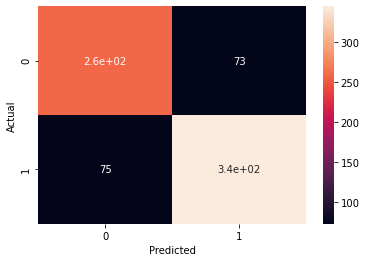

In [158]:
pred = model.predict(X_test)
y_test = y_test.flatten()

data = {
    'y_Actual': y_test,
    'y_Predicted': pred
}

df = pd.DataFrame(data, columns=['y_Actual', 'y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(confusion_matrix, annot=True)

In [161]:
train = pd.read_csv(train_data_path)
X_train = train.drop(columns='Activity')
y_train = train['Activity']

X_test = pd.read_csv(test_data_path)

X_train, X_test = normalizing(X_train, X_test)

model = LGBMClassifier(random_state=314, silent=True, n_jobs=2, subsample_freq=20, subsample=0.9,
                       reg_lambda=1.2, reg_alpha=1.1, num_leaves=200, n_estimators=800,
                       min_split_gain=0.4, max_depth=15, colsample_bytree=0.8)
model.fit(X_train, y_train)

Probability = model.predict_proba(X_test)[:,1]
MoleculeId = np.array(range(1, len(X_test) + 1))

submission = pd.DataFrame()
submission['MoleculeId'] = MoleculeId
submission['PredictedProbability'] = Probability

submission.to_csv('submission.csv', index=None)